In [1]:
import torch
import matplotlib.pyplot as plt 

import numpy as np
from cvae import CVAE, train, test, original_and_generated_for_condition
from data import Conditional
import seaborn as sns

In [2]:
# cuda setup
device = torch.device("cuda")

# hyper params
BATCH_SIZE = 64
LATENT_SIZE = 32
EPOCHS = 30
CLASS_SIZE = 7
DATA_SIZE = 10000

# create a CVAE model
model = CVAE(12*2, LATENT_SIZE, CLASS_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# define original data
datamodule = Conditional(add_condition=True, data_size=DATA_SIZE, dependent_func=torch.log)
datamodule.setup()

train_loader = datamodule.train_dataloader()
test_loader = datamodule.test_dataloader()

In [3]:
for epoch in range(1, EPOCHS + 1):
    
    train(epoch_num=epoch, 
          model=model, 
          train_loader=train_loader,
          optimizer=optimizer, 
          class_size=CLASS_SIZE, 
          device=device)
    
    test(model=model, 
         test_loader=test_loader, 
         class_size=CLASS_SIZE, 
         device=device)

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.007963
Train Epoch: 1 [2560/8000 (32%)]	Loss: 0.004513
Train Epoch: 1 [5120/8000 (63%)]	Loss: 0.003200
Train Epoch: 1 [7680/8000 (95%)]	Loss: 0.002564
====> Epoch: 1 Average loss: 0.0041
====> Test set loss: 0.0002
Train Epoch: 2 [0/8000 (0%)]	Loss: 0.002455
Train Epoch: 2 [2560/8000 (32%)]	Loss: 0.002277
Train Epoch: 2 [5120/8000 (63%)]	Loss: 0.002238
Train Epoch: 2 [7680/8000 (95%)]	Loss: 0.002215
====> Epoch: 2 Average loss: 0.0023
====> Test set loss: 0.0001
Train Epoch: 3 [0/8000 (0%)]	Loss: 0.002098
Train Epoch: 3 [2560/8000 (32%)]	Loss: 0.001956
Train Epoch: 3 [5120/8000 (63%)]	Loss: 0.001983
Train Epoch: 3 [7680/8000 (95%)]	Loss: 0.001911
====> Epoch: 3 Average loss: 0.0020
====> Test set loss: 0.0001
Train Epoch: 4 [0/8000 (0%)]	Loss: 0.001876
Train Epoch: 4 [2560/8000 (32%)]	Loss: 0.001813
Train Epoch: 4 [5120/8000 (63%)]	Loss: 0.001739
Train Epoch: 4 [7680/8000 (95%)]	Loss: 0.001784
====> Epoch: 4 Average loss: 0.0018
====> Test set loss:

In [13]:
generation_out = list(original_and_generated_for_condition(
    max_condition=CLASS_SIZE, 
    test_data=test_loader.dataset, 
    model=model, 
    latent_size=LATENT_SIZE,
    device=device
))

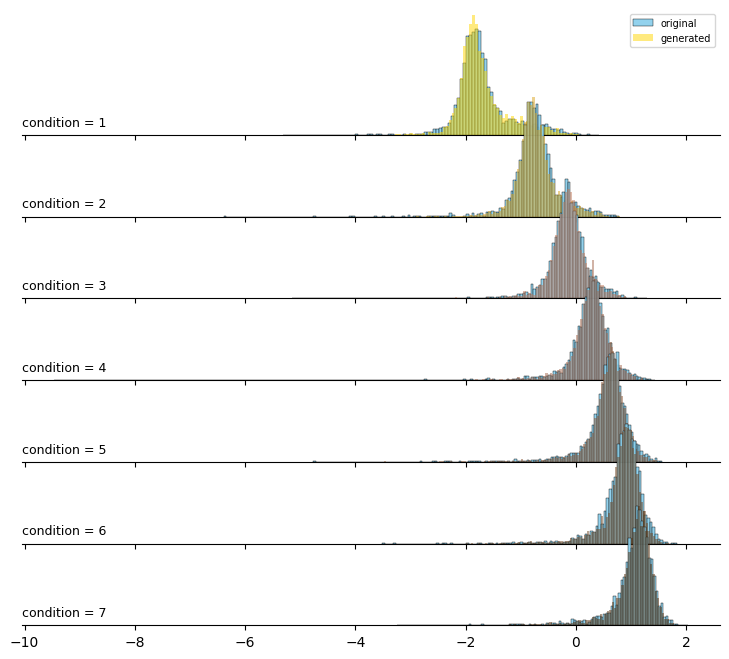

In [14]:
fig, axes = plt.subplots(CLASS_SIZE, 1,figsize=(9, 8), sharex=True)

oranges = ["#FFD700", "#DAA520", "#C07A5C", "#A5694F", "#8C5938", "#734A26", "#593716"]
for el in generation_out:
    sns.histplot(el[1][:, :, 1].flatten(), ax=axes[el[0]-1], alpha=.9, color="#87CEEB", linewidth=.3, label='original')
    sns.histplot(el[2][:, :, 1].flatten(), ax=axes[el[0]-1], alpha=0.5, color=oranges[el[0]-1], linewidth=0, label='generated')

    axes[el[0]-1].yaxis.set_visible(False)
    axes[el[0]-1].patch.set_alpha(0)
    axes[el[0]-1].spines['top'].set_visible(False)
    axes[el[0]-1].spines['right'].set_visible(False)
    axes[el[0]-1].spines['left'].set_visible(False)

    axes[el[0]-1].text(0, .1, f'condition = {el[0]}', color='black', fontsize=9,
            ha="left", va="center", transform=axes[el[0]-1].transAxes)
axes[0].legend(fontsize="7")
fig.subplots_adjust(hspace=-.35)

In [ ]:
    # hist_vals_original, bin_edges = np.histogram(el[1][:, :, 1].flatten(), bins=60)
    # hist_vals_generated, bin_edges = np.histogram(el[2][:, :, 1].flatten(), bins=bin_edges[:-1])

    # axes[el[0]-1].bar(x=bin_edges, height=hist_vals_original, width=bin_edges[1]-bin_edges[0], alpha=1, label='original', color="#87CEEB", edgecolor='black', linewidth=.2)
    # axes[el[0]-1].bar(x=bin_edges[:-1], height=hist_vals_generated, width=bin_edges[1]-bin_edges[0], alpha=0.5, label='generated', color=oranges[el[0]-1])
    